## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [5]:
import simulators.mass_function_n_counts.simulator_trapz_m500_1 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_m500_1' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_1.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [7]:
theta_fiducial = np.array([0.1197, 0.76])


## Define mass calibration parameters

In [8]:
mass_calibration_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']
theta_fiducial_mass_calibration = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [11]:
theta_total = np.concatenate((theta_fiducial, theta_fiducial_mass_calibration))

In [12]:
z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
n_steps_z = 100
n_bins_z = len(z_min)


n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

n_steps_Mz = n_steps_z*n_steps_M_500

#Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16)]
Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16),
                 np.logspace(np.log10(4.3e-12), np.log10(5.1e-10), num = 15),
                 np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 16),
                 np.logspace(np.log10(3.1e-12), np.log10(1.1e-10), num = 14),
                 np.logspace(np.log10(2.5e-12), np.log10(6.6e-11), num = 13)]
n_steps_Y = 100

In [30]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_m500_1' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_1.py'>

In [31]:
N_countsSimulator = n_counts_simulator.Model()

/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_1.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


In [28]:
N_countsSimulator.N_counts

[array([9.71515551e+03, 6.63710787e+03, 4.43788626e+03, 2.90023461e+03,
        1.85063232e+03, 1.15260489e+03, 7.01000871e+02, 4.16925048e+02,
        2.43076563e+02, 1.39363454e+02, 7.88484399e+01, 4.41678004e+01,
        2.45607765e+01, 1.35832685e+01, 7.47964329e+00]),
 array([1.18968596e+04, 7.73542768e+03, 4.88169927e+03, 2.98026291e+03,
        1.75366385e+03, 9.90593491e+02, 5.34788185e+02, 2.74598377e+02,
        1.33383718e+02, 6.09218025e+01, 2.59877509e+01, 1.02753886e+01,
        3.73367687e+00, 1.23459864e+00]),
 array([5.28808066e+03, 3.43173877e+03, 2.16851216e+03, 1.33092109e+03,
        7.91363649e+02, 4.54527362e+02, 2.51390254e+02, 1.33448269e+02,
        6.77300284e+01, 3.27369306e+01, 1.50030434e+01, 6.48727994e+00,
        2.63355080e+00, 9.97725635e-01, 3.50639895e-01]),
 array([1.24165158e+03, 7.01424667e+02, 3.81165336e+02, 1.98545512e+02,
        9.87306286e+01, 4.66900318e+01, 2.08944762e+01, 8.80574858e+00,
        3.47644079e+00, 1.27751431e+00, 4.34516542

In [32]:
N_countsSimulator.simulation(theta_total, 1)

[array([9692, 6539, 4371, 2884, 1841, 1121,  695,  392,  234,  155,   64,
          37,   17,   22,    8]),
 array([11996,  7722,  4839,  2909,  1776,   968,   484,   255,   140,
           59,    25,    11,     5,     2]),
 array([5421, 3476, 2233, 1359,  772,  450,  259,  132,   65,   42,   13,
           8,    3,    4,    0]),
 array([1120,  681,  383,  215,   92,   41,   19,    5,    1,    2,    0,
           1,    0]),
 array([374, 181,  85,  44,  13,   8,   3,   0,   0,   0,   0,   0])]

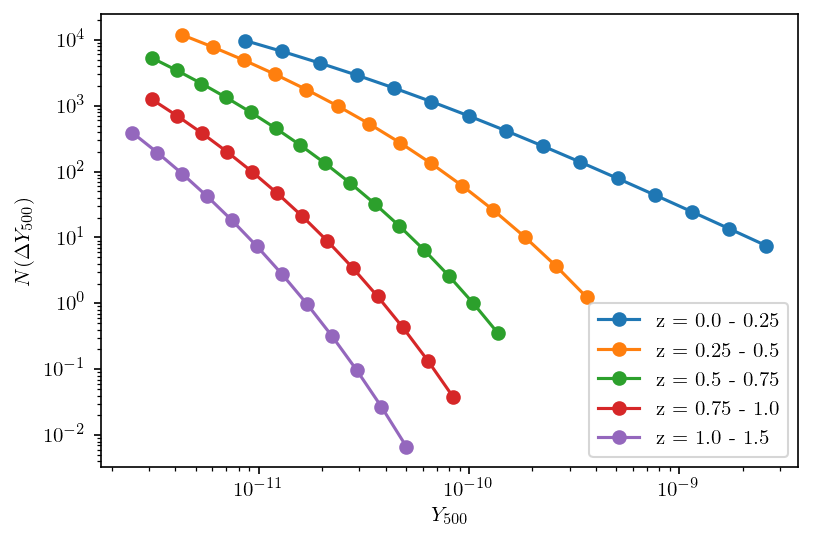

In [33]:
plt.figure()
plt.ylabel(r'$N(\Delta Y_{500})$')
plt.xlabel(r'$Y_{500}$')
plt.xscale('log')
plt.yscale('log')
for i in range(len(z_max)):
    plt.plot(Y_bins_limits[i][:-1], N_counts[i], c=color_map(i), marker = 'o', 
             label = 'z = {z_min} - {z_max}'.format(z_min = z_min[i], z_max = z_max[i]))
plt.legend(loc = 'best')